### There is more confusion on whether grid should be used in machine learning or are we using averages from dataset to setup a model
### Untill that is clear, the ML works stops here

In [1]:
#read all the data and filter for only some
from ml_utils import *
import time

In [2]:
#get the required clusters 
client = get_cluster("UCSB0021", cores = 40)
client.cluster

In [18]:
#modify the function if you want to pass the parameter
def read_all_simulation():
    '''prepare cluster list and read to create ensemble(group of data)
    use preprocess to select only certain dimension and a variable'''
    # Start timing
    start_time = time.time()

    # read all simulations as a list
    cluster_list = sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2005-02-01-00000.nc'))
    cluster_list = cluster_list[1:len(cluster_list)]

    # only select latitude, longitude, time, and using this in preprocess steps
    def preprocess(ds):
        '''using this function in xr.open_mfdataset as preprocess
        ensures that when only these four things are selected
        before the data is combined'''
        ds = fix_time(ds)
        ds = ds[['lat', 'lon', 'time', 'LEAFCN', 'LEAFN', 'TSA']]
        return ds
    
    # read the list and load it for the notebook
    ds = xr.open_mfdataset(cluster_list,
                              combine='nested',
                              preprocess=lambda ds: preprocess(ds),
                              parallel=True,
                              concat_dim="ens")

    # End timing
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Time taken to run read_all_simulation(): {:.2f} seconds".format(elapsed_time))
    return ds
   

In [19]:
ds = read_all_simulation()
ds

Time taken to run read_all_simulation(): 12.41 seconds


<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, time: 60, ens: 500, gridcell: 400)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 2005-01-01 00:00:00 ... 2009-12-01 00:00:00
Dimensions without coordinates: ens, gridcell
Data variables:
    LEAFCN   (ens, time, gridcell) float32 dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
    LEAFN    (ens, time, gridcell) float32 dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
    TSA      (ens, time, gridcell) float32 dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 08/10/23 00:09:45
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_transient_LHC0001.clm...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

**The weight_landarea_gridcells function available inside the utils is designed only for dataarray, 
I am changing to work with dataset.**

In [20]:
#read the landarea data
landarea = xr.open_dataset('/glade/campaign/cgd/tss/projects/PPE/helpers/sparsegrid_landarea.nc')['landarea']

def weight_landarea_gridcells(ds, landarea):
    for varname in ds.variables:
        # Skip coordinates and auxiliary variables
        if varname not in ds.coords:
            var = ds[varname]
            # Calculate the weighted mean of the variable over grid cells
            weighted_mean = var.weighted(landarea).mean(dim='gridcell')
            # Assign the weighted mean back to the dataset
            ds[varname] = weighted_mean
    return ds
   

**The dataset is weighted by gridcells at this point** 

In [22]:
ds = weight_landarea_gridcells(ds, landarea)
ds

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, time: 60, ens: 500)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 2005-01-01 00:00:00 ... 2009-12-01 00:00:00
Dimensions without coordinates: ens
Data variables:
    LEAFCN   (ens, time) float64 dask.array<chunksize=(1, 60), meta=np.ndarray>
    LEAFN    (ens, time) float64 dask.array<chunksize=(1, 60), meta=np.ndarray>
    TSA      (ens, time) float64 dask.array<chunksize=(1, 60), meta=np.ndarray>
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 08/10/23 00:09:45
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_transient_LHC0001.clm...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

**Weight the dataset based on yearly average. Note: these functions are designed to workwith dataset and not with datarray and these functions are also different from what is available in utils. We have to change in the utils later**

In [25]:
def yearly_weighted_average(ds):
    for varname in ds.variables:
        # Skip coordinates and auxiliary variables
        if varname not in ds.coords:
            var = ds[varname]
            # Get the array of number of days from the main dataset
            days_in_month = ds['time.daysinmonth']

            # # Multiply each month's data by corresponding days in month
            weighted_month = (days_in_month * var).groupby("time.year").sum(dim='time')

            # # Total days in the year
            total_days = days_in_month.groupby("time.year").sum(dim='time')

            #  Calculate weighted average for the year
            ds[varname] = weighted_month / total_days

            #appy total average here
            ds[varname] = ds[varname].mean(dim = "year")

    return ds


In [37]:
ds_final  = yearly_weighted_average(ds)
ds_final

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, time: 60, ens: 500, year: 5)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 2005-01-01 00:00:00 ... 2009-12-01 00:00:00
  * year     (year) int64 2005 2006 2007 2008 2009
Dimensions without coordinates: ens
Data variables:
    LEAFCN   (ens) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    LEAFN    (ens) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    TSA      (ens) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 08/10/23 00:09:45
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_transient_LHC0001.clm...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

In [30]:
## calculate the total average
# year = ds_test["time"].dt.year
# decade = ((year - year[0]) / 5).astype(int)
# ds_test["decade"] = decade

# ds_test = ds_test.set_coords("decade")
# ds_test = ds_test.groupby("ens").mean(dim = "decade")
# ds_test

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, time: 60, ens: 500)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 2005-01-01 00:00:00 ... 2009-12-01 00:00:00
Dimensions without coordinates: ens
Data variables:
    LEAFCN   (ens) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    LEAFN    (ens) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    TSA      (ens) float64 dask.array<chunksize=(1,), meta=np.ndarray>

**Make sure not to run single chunk for above functions, either run all of them or none**

##### The whole function of reading all simulations will be used only when all things are ready, for now it is of no use, so can be saved as raw.

In [ ]:
#-----------steps involves
#work with one piece of data only
#split up the chunk
#setup univariate gaussian 
#fit the gaussian cost function between leafcn and
#plot the raw lines without any hyperparamter change

#### The function is tested with single simulation of 1000 dataset only 

In [38]:
#create an array for both leafn and Leafcn
leafn =  ds_final["LEAFN"].values
leafcn = ds_final["LEAFCN"].values

lat = ds_final['lat'].values
lon = ds_final ['lon'].values
time = ds_final ['time'].values


In [44]:
#flatten the list to single column, i tried without flattening that does not make sense
leafn = np.array(leafn)
leafcn = np.array(leafcn)

#there should be no missing values becuase machine does not learn anything from
#that and it also does not how to interpret the data
np.unique(leafn)
np.isnan(leafcn).sum()

0

#### The K nearest method imputer makes more sense to me because I can use four nearby grid cells values
#### to impute the nan values

In [45]:
from sklearn.impute import KNNImputer

# Create a KNN imputer with k=4 (number of neighbors), not required for leafn as it no na values
knn_imputer = KNNImputer(n_neighbors=4)
leafcn= knn_imputer.fit_transform(np.array(leafcn).reshape(-1,1))


#### Data is cleaned, and it can be now fit using machine learning. But, this data should be shuffled
#### otherwise there is specific grid and time and model won't perform better. So, do random arrnagement of the 
#### values keeping the relationships of input and output

In [46]:
import numpy as np

# Assuming leafn and leafcn have the same length
num_samples = len(leafn)
indices = np.arange(num_samples)
np.random.shuffle(indices)

# Shuffle leafn and leafcn using the shuffled indices
shuffled_leafn = leafn[indices]
shuffled_leafcn = leafcn[indices]


#### Data preprocessing and selecting only 1000 rows

In [51]:
# split the dataset into xtrain and ytrain 
from sklearn.model_selection import train_test_split

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(shuffled_leafn, 
                                                    shuffled_leafcn, 
                                                    test_size=0.2, 
                                                    random_state=42)

# #---------use standard scaler to transform the dataset
# from sklearn.preprocessing import StandardScaler

# # Create StandardScaler objects
# train_x_scale= StandardScaler()

# # Fit the scalers to the data and transform the data
X_train= np.array(X_train).reshape(-1, 1)
X_test =  np.array(X_test).reshape(-1, 1)

array([[4.99703952],
       [2.89573171],
       [3.78330259],
       [0.53508046],
       [2.83303719],
       [2.43944408],
       [4.5406712 ],
       [3.14433659],
       [5.20253619],
       [6.31673136],
       [7.3584572 ],
       [5.07872983],
       [4.41486785],
       [2.30944015],
       [3.83520001],
       [3.73452376],
       [3.8222372 ],
       [4.8820372 ],
       [3.24470325],
       [4.04093914],
       [4.64138081],
       [2.14587702],
       [2.6728066 ],
       [2.82662534],
       [3.26181957],
       [2.15228499],
       [3.1674196 ],
       [4.7935678 ],
       [3.50611686],
       [1.13255108],
       [2.16550198],
       [2.98937666],
       [4.34009168],
       [2.15437593],
       [3.56906488],
       [5.50159208],
       [2.91565869],
       [2.01406656],
       [2.64493127],
       [2.42426535],
       [2.55156289],
       [3.12281328],
       [3.67695603],
       [2.22160063],
       [4.95806568],
       [3.39162336],
       [0.40647721],
       [2.955

#### This is based model with no hyperparameter changing, no cross validation


In [66]:

#two packages that can be used to instantiate the gaussian model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

#instantiate the model and tune nothing in the beginning
kernel = ConstantKernel(constant_value = 3, constant_value_bounds=(1e-2, 1e4)) \
              * RBF(length_scale=1, length_scale_bounds=(1e-4, 1e8))
gp_model = GaussianProcessRegressor(kernel=kernel, random_state=42)

# Fit the model to the training data
gp_model.fit(X_train, y_train)

# Verify training score
train_score = gp_model.score(X_train, y_train)
print("Training Score:", train_score)

predictions = gp_model.predict(X_test)

#gp_model.predict(X_test)

Training Score: 1.0


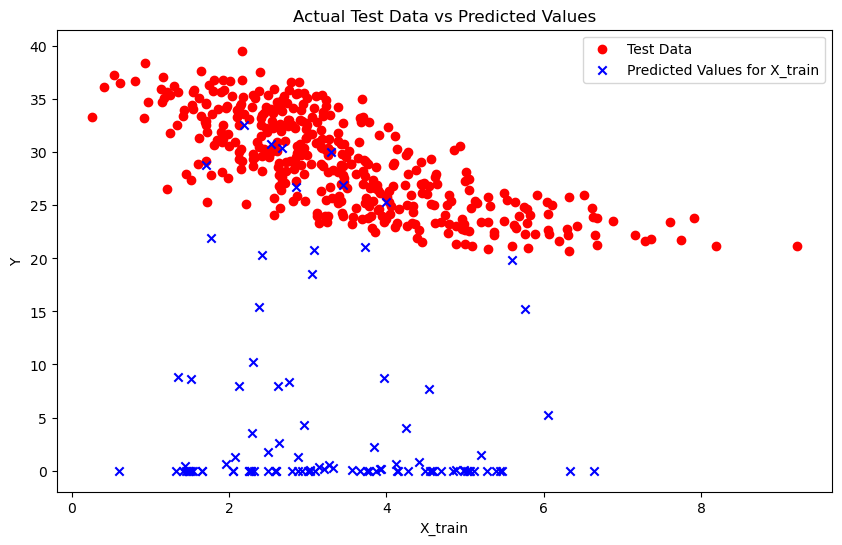

In [77]:
# # Generate predictions for X_train
# y_pred_train = gp_model.predict(X_train)

# # Plot the actual test data against the predicted values for X_train
# plt.figure(figsize=(10, 6))
# plt.scatter(X_train, y_train, color='red', label='Test Data')
# plt.scatter(X_test, predictions, color='blue', label='Predicted Values for X_train', marker='x')
# #plt.plot(X_train, y_pred_train, color='blue', linestyle='-', label='Gaussian Regression Line (X_train)')
# plt.xlabel('X_train')
# plt.ylabel('Y')
# plt.title('Actual Test Data vs Predicted Values')
# plt.legend()
# plt.show()



#### This is a model with 4 folds cross validation, 500 datasets too small so 4 folds cross validation should be okay.

In [107]:
#use kfold validation to train the model
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
import time

# Define the number of folds for cross-validation
n_splits = 5

#starttime for model run
start_time = time.time()

# Define the Gaussian Process model
kernel = RBF(length_scale_bounds="fixed")
# kernel = ConstantKernel(constant_value = 3, constant_value_bounds=(1e-5, 1e5)) \
#               * RBF(length_scale=1, length_scale_bounds=(1e-5, 1e5))
gp_model_cv = GaussianProcessRegressor(kernel=kernel, random_state=42, n_restarts_optimizer= 4,
                                       alpha= 0.5, normalize_y = True)

# Perform k-fold cross-validation and calculate MAE for each fold
mae_scores = cross_val_score(gp_model_cv, X_train, y_train, cv = n_splits, scoring='neg_mean_absolute_error')

print(mae_scores)

gp_model_cv.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gp_model_cv.predict(X_test)

# Calculate Mean Absolute Error on the test set
mae_test = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae_test)

[-2.44000879 -2.30533798 -2.58486823 -2.36374365 -2.09359653]
Test MAE: 2.2232492315764008


In [105]:
# I don't understand why model only predicting zeros, tried all possible approaches
cv_predictions = gp_model_cv.predict(X_test)

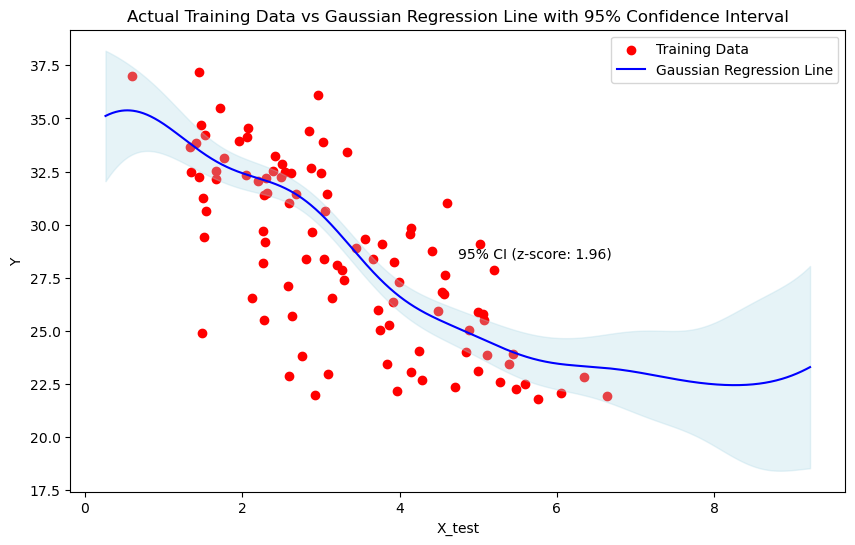

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define a custom function to generate the Gaussian regression line
def gaussian_regression_line(model, X):
    # Generate evenly spaced values along the x-axis
    x_values = np.linspace(min(X), max(X), 1000).reshape(-1, 1)
    # Predict mean and standard deviation of the Gaussian process at each point in x_values
    y_mean, y_std = model.predict(x_values, return_std=True)
    # Plot the mean line
    plt.plot(x_values, y_mean, color='blue', linestyle='-', label='Gaussian Regression Line')
    
    # Calculate the z-score for the 95% confidence interval
    z_score = norm.ppf(0.975)  # 97.5th percentile
    
    # Plot the shaded region for the 95% confidence interval
    plt.fill_between(x_values.flatten(), y_mean - z_score * y_std, y_mean + z_score * y_std, color='lightblue', alpha=0.3)
    
    # Plot the z-score value on the plot
    plt.text(0.5, 0.5, f'95% CI (z-score: {z_score:.2f})', transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom')

# Plot the actual training data against the predicted values
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='red', label='Training Data')
gaussian_regression_line(gp_model_cv, X_train)
plt.xlabel('X_test')
plt.ylabel('Y')
plt.title('Actual Training Data vs Gaussian Regression Line with 95% Confidence Interval')
plt.legend()
plt.show()


